In [ ]:
!pip install gensim
!pip install numpy==1.23.5

In [ ]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
resume_match_df = pd.read_csv("https://raw.githubusercontent.com/samariwa/artificial-intelligence-projects/refs/heads/main/AI%20Assessment/data.csv").sample(frac=1)
resume_match_df = resume_match_df.head(2000)

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def tokenize_text(text):
    """
    tokenize_text(text)
    This function will tokenize the texts from the resumes and job descriptions
    This will be first preprocessed by removing stop words that add no semantic value
    and lemmatized for a standardized set of words
    text(string): the text to be tokenized
    returns: list of tokens generated from the text passed in as an arg
    """
    doc = nlp(text.lower())
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

In [ ]:
# initialize string that will contain tokens for each resume and job description
preprocessed_resume_text = []
preprocessed_jd_text = []
for i in tqdm(range(len(resume_match_df))):
    preprocessed_resume_text.append(tokenize_text(resume_match_df.iloc[i]['resume_text']))
    preprocessed_jd_text.append(tokenize_text(resume_match_df.iloc[i]['job_description_text']))

100%|██████████| 2000/2000 [08:45<00:00,  3.80it/s]


In [ ]:
# convert the tokens in each list back to strings
resume_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_resume_text)]
jd_texts = [" ".join(tokens) for tokens in tqdm(preprocessed_jd_text)]
'''
combine the resume and job description texts before count vectorizing
In each row we represent the tokens as values counts for the number of
times they appear in the document
'''
corpus = resume_texts + jd_texts

100%|██████████| 2000/2000 [00:00<00:00, 37229.75it/s]


## Vectorization using the Bag of Words Vectorizer

In [ ]:
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(corpus)
resume_bow = bow_matrix[:len(resume_texts)].toarray()
jd_bow = bow_matrix[len(resume_texts):].toarray()

In [ ]:
# we horizontally stack JDs and resumes so that we have numeric representations od words for JDs and corresponding resume
X = np.hstack((resume_bow, jd_bow))
# this representation created above will be set against the job-match decision
y = resume_match_df['label'].values

### Run classification of the data using various algorithms

In [ ]:
def classify_k_fold_x_validation(model, x_data, y_data, folds):
    """
    classify_k_fold_x_validation(model, x_data, y_data, folds)
    """
    accuracy_scores = []
    classifier = model()
    k_fold = KFold(n_splits=folds, shuffle=False)
    for train_idx, test_idx in k_fold.split(x_data):
        X_train, X_test, y_train, y_test = x_data[train_idx], x_data[test_idx], y_data[train_idx], y_data[test_idx]
        classifier.fit(X_train, y_train)
        accuracy_scores.append(classifier.score(X_test, y_test))

    return accuracy_scores

In [ ]:
def model_validation(x_data, y_data, folds=10):
    """
    model_validation(x_data, y_data, folds=10)
    Validates performance of various models
    """
    models = {'K-Nearest Neighbors': 'KNeighborsClassifier',
              'Decision Tree': 'DecisionTreeClassifier',
              'Random Forest': 'RandomForestClassifier',
              'Support Vector Classifier': 'SVC',
              'Gaussian Naive Bayes': 'GaussianNB'}
    model_performance = {}
    for model_name, model_function in tqdm(models.items()):
        accuracies = classify_k_fold_x_validation(eval(model_function), x_data, y_data, folds)
        model_performance[model_name] = accuracies
    plt.figure(figsize=(12, 6))
    plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))
    plt.title('Classification Performance Comparison with K-Fold Cross Validation')
    plt.xlabel('Classifier Model')
    plt.ylabel('Accuracy Scores')
    plt.show()

100%|██████████| 5/5 [41:26<00:00, 497.23s/it]
<ipython-input-11-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


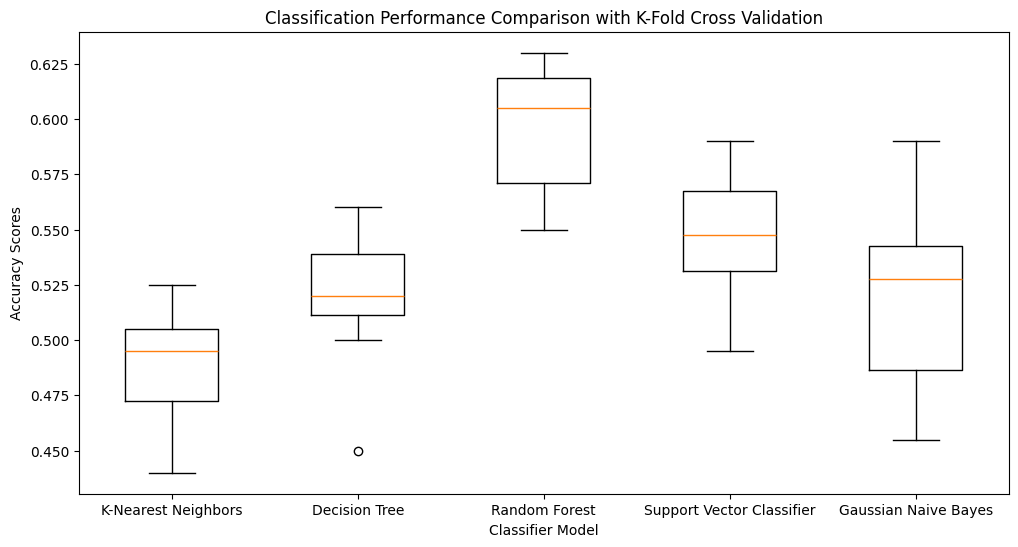

In [ ]:
model_validation(X, y, folds=10)

In [ ]:
# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.62


## Vectorization using TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
resume_tfidf = tfidf_vectorizer.fit_transform(resume_texts)
jd_tfidf = tfidf_vectorizer.fit_transform(jd_texts)

2000

In [ ]:
X = hstack((resume_tfidf, jd_tfidf)).toarray()
y = resume_match_df['label'].values

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.07783684],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

100%|██████████| 5/5 [25:45<00:00, 309.12s/it]
<ipython-input-11-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


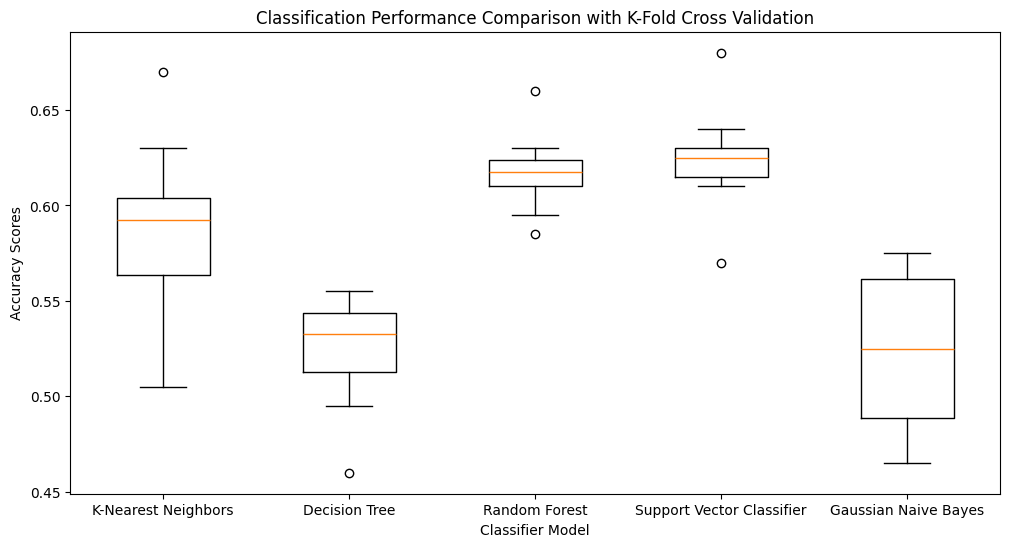

In [ ]:
model_validation(X, y, folds=10)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.65


### TF-IDF Cosine Similarity Evaluation

We combine resume and JD text together because cosine similarity compares vectors of the same dimension

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus)

# split back to resume and jd matrices
cos_sim_resume_tfidf = tfidf_matrix[:len(resume_texts)]
cos_sim_jd_tfidf = tfidf_matrix[len(resume_texts):]

similarity_scores = [cosine_similarity(cos_sim_resume_tfidf[i], cos_sim_jd_tfidf[i])[0][0] for i in range(len(resume_tfidf.toarray()))]

In [ ]:
def classify_similarity_scores(scores):
  similarity_scores = []
  for score in scores:
    if score >= 0.2:
      similarity_scores.append("Good Fit")
    elif score >= 0.1 and score < 0.2:
      similarity_scores.append("Potential Fit")
    elif score < 0.1:
      similarity_scores.append("No Fit")

  predictions = pd.DataFrame(similarity_scores)

  return predictions

cos_sim_pred = classify_similarity_scores(similarity_scores)

In [ ]:
# Evaluate Model
accuracy = accuracy_score(y, cos_sim_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.48


## Vectorization using Word2Vec

In [ ]:
# Combine preprocessed resume and JD tokens for training Word2Vec
all_tokens = preprocessed_resume_text + preprocessed_jd_text

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=all_tokens, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec vector for a document
def get_vector(tokens, model, vector_size=100):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size)

# Convert resumes & JDs into numerical vectors
resume_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_resume_text])
jd_vectors = np.array([get_vector(tokens, word2vec_model) for tokens in preprocessed_jd_text])

X = np.hstack((resume_vectors, jd_vectors))
y = resume_match_df['label'].values

100%|██████████| 5/5 [00:30<00:00,  6.05s/it]
<ipython-input-11-0c08bdfe2a30>:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(list(model_performance.values()), labels=list(model_performance.keys()))


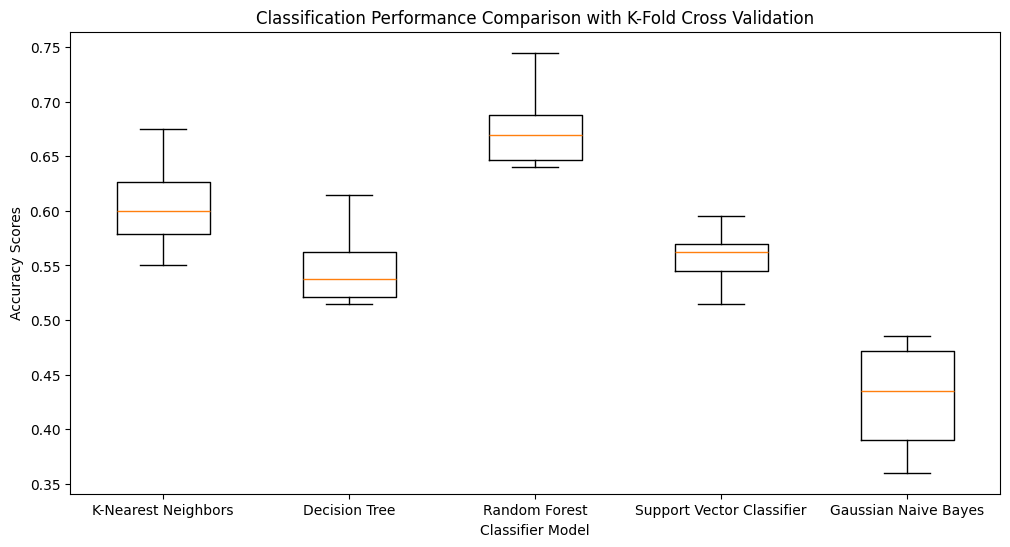

In [ ]:
model_validation(X, y, folds=10)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluate Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.71
